In [76]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from dotenv import load_dotenv;load_dotenv() # noqa

db_connection_str = os.getenv("DB_CONNECTION_STR")

%load_ext sql
%config SqlMagic.displaycon = False
%config SqlMagic.feedback = False
%sql {db_connection_str}

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


In [77]:
%sql select * from online_retail_clean limit 3;

country,customer_id,invoice_date,invoice,stock_code,description,quantity,price,invoice_amount
Australia,12386,2010-12-08,537676,21906,PHARMACIE FIRST AID TIN,4,6.75,27.00
Australia,12386,2010-12-08,537676,22495,SET OF 2 ROUND TINS CAMEMBERT,6,2.95,17.70
Australia,12386,2010-12-08,537676,22555,PLASTERS IN TIN STRONGMAN,12,1.65,19.80


In [78]:
%%sql result <<
with monthly_net_sales as (
    select
        to_char(date_trunc('month', invoice_date), 'YYYY-MM') as invoice_month,
        sum(invoice_amount) as net_revenue
    from online_retail_clean
    group by
        invoice_month
)
select
    *,
    lag(net_revenue) over (order by invoice_month) as prior_month,
    net_revenue - lag(net_revenue) over (order by invoice_month) as mom_actual_change,
    ROUND(
        (net_revenue - LAG(net_revenue) OVER (ORDER BY invoice_month))
        / NULLIF(LAG(net_revenue) OVER (ORDER BY invoice_month), 0) * 100
    , 2) as mom_growth_pct
from monthly_net_sales
order by invoice_month
;

Returning data to local variable result


In [79]:
df_net_monthly = result.DataFrame()
df_net_monthly.head(3)

,invoice_month,net_revenue,prior_month,mom_actual_change,mom_growth_pct
0,2010-01,622479.50,None,None,None
1,2010-02,531265.36,622479.50,-91214.14,-14.65
2,2010-03,763247.24,531265.36,231981.88,43.67


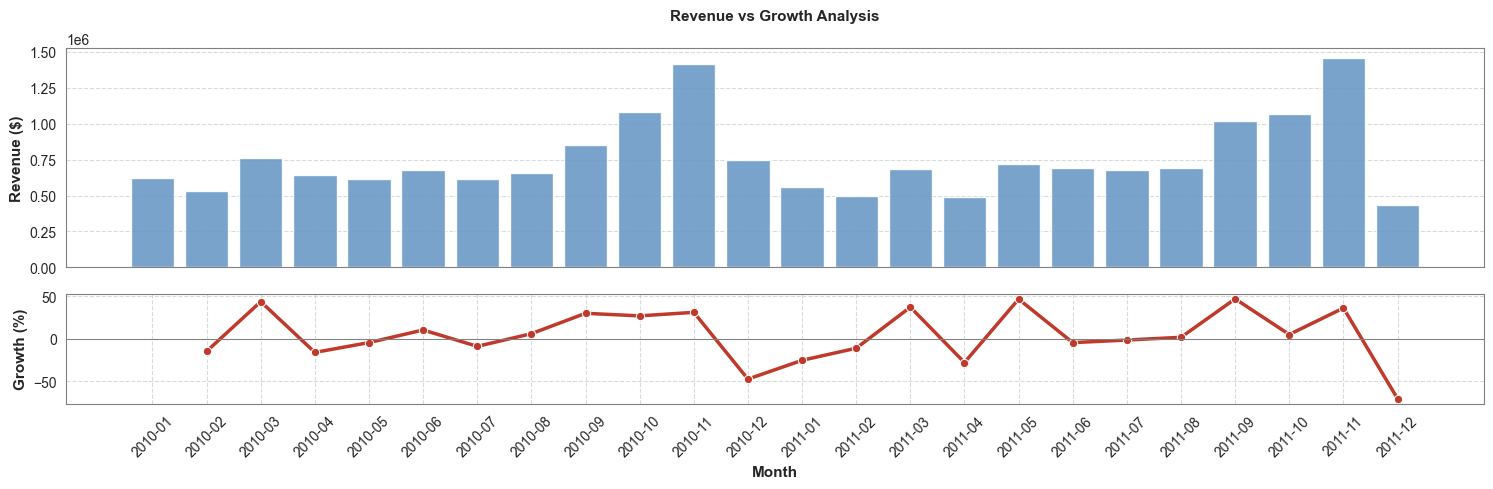

In [80]:
# styling
bar_color = "#5C99D5"
line_color = '#c0392b'
grid_color = '#bdc3c7'

# 2 Rows, 1 Column (Standard Time Series)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 5), sharex=True, gridspec_kw={'height_ratios': [2, 1]})

# --- CHART 1: REVENUE ---
sns.barplot(data=df_net_monthly, x='invoice_month', y='net_revenue', color=bar_color, alpha=0.9, ax=ax1)
ax1.grid(True, axis='y', linestyle='--', alpha=0.6, color=grid_color) # Horizontal Grid only
ax1.set_ylabel('Revenue ($)', fontsize=11, fontweight='bold')
ax1.set_title('Revenue vs Growth Analysis', fontsize=11, fontweight='bold', pad=20)
# Add a border
for spine in ax1.spines.values():
    spine.set_visible(True)
    spine.set_color('grey')

# --- CHART 2: GROWTH ---
sns.lineplot(data=df_net_monthly, x='invoice_month', y='mom_growth_pct', color=line_color, marker='o', linewidth=2.5, ax=ax2)
ax2.axhline(0, color='grey', linewidth=0.75)
ax2.grid(True, linestyle='--', alpha=0.6, color=grid_color) # Full Grid
ax2.set_ylabel('Growth (%)', fontsize=11, fontweight='bold')
ax2.set_xlabel('Month', fontsize=11, fontweight='bold')
ax2.tick_params(axis='x', rotation=45)
# Add a border
for spine in ax2.spines.values():
    spine.set_visible(True)
    spine.set_color('grey')

plt.tight_layout()
plt.show()

In [81]:
%%sql result_quarterly <<
-- Save this result to a variable for Python plotting
SELECT
    TO_CHAR(DATE_TRUNC('quarter', invoice_date), 'YYYY-"Q"Q') as quarter_label, -- e.g. "2010-Q1"
    TO_CHAR(DATE_TRUNC('quarter', invoice_date), '"Q"Q') as quarter_only,       -- e.g. "Q1"
    TO_CHAR(DATE_TRUNC('year', invoice_date), 'YYYY') as year_label,            -- e.g. "2010"
    SUM(invoice_amount) as net_revenue
FROM online_retail_clean
GROUP BY 1, 2, 3
ORDER BY 1;

Returning data to local variable result_quarterly


In [82]:
df_net_quarterly = result_quarterly.DataFrame()
df_net_quarterly

,quarter_label,quarter_only,year_label,net_revenue
0,2010-Q1,Q1,2010,1916992.10
1,2010-Q2,Q2,2010,1931865.64
2,2010-Q3,Q3,2010,2123245.83
3,2010-Q4,Q4,2010,3244032.29
4,2011-Q1,Q1,2011,1737488.95
5,2011-Q2,Q2,2011,1904439.17
6,2011-Q3,Q3,2011,2390198.29
7,2011-Q4,Q4,2011,2958233.09


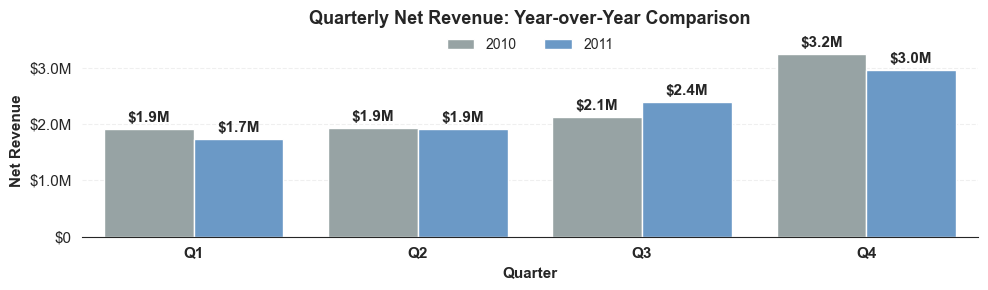

In [83]:
from matplotlib.ticker import FuncFormatter

# Define a formatter function (e.g., 1,500,000 -> $1.5M)
def number_format(x, pos=None):
    if x >= 1e6:
        return f'${x*1e-6:.1f}M'
    elif x >= 1e3:
        return f'${x*1e-3:.0f}K'
    return f'${x:.0f}'

# Create the Chart
plt.figure(figsize=(10, 3)) # canvas size
sns.set_style("white")

# Plot
ax = sns.barplot(
    data=df_net_quarterly,
    x='quarter_only',
    y='net_revenue',
    hue='year_label',
    palette=["#95a5a6", "#5C99D5"] # Grey vs Dark Blue
)

# Apply the Formatting to the Y-Axis
ax.yaxis.set_major_formatter(FuncFormatter(number_format))

# Styling with Larger Fonts
plt.title('Quarterly Net Revenue: Year-over-Year Comparison', fontsize=13, fontweight='bold', pad=15)
plt.xlabel('Quarter', fontsize=11, fontweight='bold')
plt.ylabel('Net Revenue', fontsize=11, fontweight='bold')
plt.legend(
           loc='upper center',
           title_fontsize='10',
           bbox_to_anchor=(0.5, 1.1),
           ncol=2,
           frameon=False)
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.xticks(fontsize=11, fontweight='bold')
plt.yticks(fontsize=11)

# Add formatted value labels on top of bars
for container in ax.containers:
    # Create custom labels using format function
    labels = [number_format(v) if v > 0 else '' for v in container.datavalues]
    ax.bar_label(container, labels=labels, padding=3, fontsize=11, fontweight='bold')

# Clean up
sns.despine(left=True)
plt.tight_layout()
plt.show()

In [84]:
%%sql
with cte as (
    select
        'Q' || extract(quarter from invoice_date) quarter,
        sum(invoice_amount) filter (where extract(year from invoice_date) = 2010) sales_2010,
        sum(invoice_amount) filter (where extract(year from invoice_date) = 2011) sales_2011
    from online_retail_clean
    group by
        quarter
)
select
    *,
    round((sales_2011 - sales_2010) / sales_2010 *100, 2) yoy_growth_pct
from cte
;

quarter,sales_2010,sales_2011,yoy_growth_pct
Q1,1916992.10,1737488.95,-9.36
Q2,1931865.64,1904439.17,-1.42
Q3,2123245.83,2390198.29,12.57
Q4,3244032.29,2958233.09,-8.81


In [85]:
%%sql monthly_revenue <<
with sales_cte as (
    select
        extract(month from invoice_date) invoice_mth,
        sum(invoice_amount) filter (where extract(year from invoice_date) = 2010) as revenue_2010,
        sum(invoice_amount) filter (where extract(year from invoice_date) = 2011) as revenue_2011
    from online_retail_clean
    group by 1
)
select
    *
from sales_cte
order by invoice_mth
;

Returning data to local variable monthly_revenue


In [86]:
df_monthly_revenue = monthly_revenue.DataFrame()
df_monthly_revenue.tail(3)

,invoice_mth,revenue_2010,revenue_2011
9,10,1080611.48,1069368.23
10,11,1416697.20,1456145.80
11,12,746723.61,432719.06


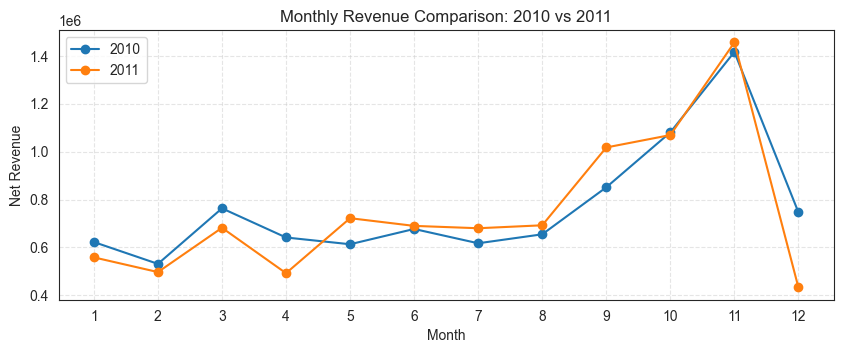

In [87]:
plt.figure(figsize=(10, 3.5))

# Plot lines directly from the columns
plt.plot(df_monthly_revenue['invoice_mth'], df_monthly_revenue['revenue_2010'], marker='o', label='2010')
plt.plot(df_monthly_revenue['invoice_mth'], df_monthly_revenue['revenue_2011'], marker='o', label='2011')

# Formatting
plt.title('Monthly Revenue Comparison: 2010 vs 2011')
plt.xlabel('Month')
plt.ylabel('Net Revenue')
plt.xticks(df_monthly_revenue['invoice_mth'])
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

plt.show()

In [88]:
%%sql revenue_dow <<
select
    to_char(invoice_date, 'month') as month_name,
    to_char(invoice_date, 'day') as day_of_week,
    sum(invoice_amount) as net_revenue -- include return/refund
from online_retail_clean
group by
    1, 2, extract(month from invoice_date), extract(isodow from invoice_date)
order by
    extract(month from invoice_date), extract(isodow from invoice_date)
;

Returning data to local variable revenue_dow


In [89]:
df_revenue_dow = revenue_dow.DataFrame()
df_revenue_dow.head(3)

,month_name,day_of_week,net_revenue
0,january,monday,195728.64
1,january,tuesday,267057.14
2,january,wednesday,140492.17


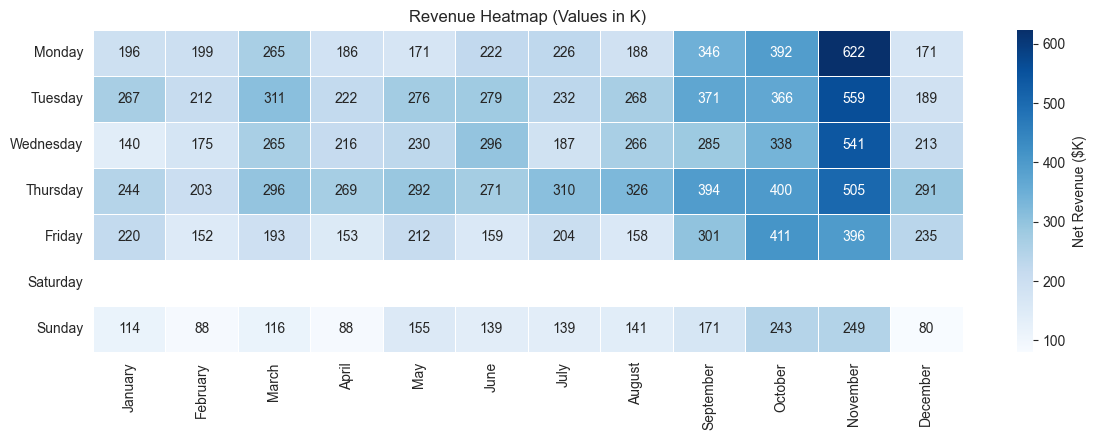

In [90]:
# Ensure string consistency (optional but recommended for SQL outputs)
df_revenue_dow['day_of_week'] = df_revenue_dow['day_of_week'].str.strip().str.title()
df_revenue_dow['month_name'] = df_revenue_dow['month_name'].str.strip().str.title()
df_revenue_dow['net_revenue'] = pd.to_numeric(df_revenue_dow['net_revenue'], errors='coerce')

# Pivot the Data
# Rows = Days, Columns = Months, Values = Revenue
heatmap_data = df_revenue_dow.pivot(index='day_of_week', columns='month_name', values='net_revenue')

# Enforce Chronological Sorting
# Define the correct order
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
months_order = ['January', 'February', 'March', 'April', 'May', 'June',
                'July', 'August', 'September', 'October', 'November', 'December']

# Reindex the pivot table to force this order
heatmap_data = heatmap_data.reindex(index=days_order, columns=months_order)

# Scale the data to 'Thousands' (K)
heatmap_data_k = heatmap_data / 1000

plt.figure(figsize=(12, 4.5))

# Plot with integer formatting (fmt='.0f')
sns.heatmap(heatmap_data_k,
            cmap='Blues',
            annot=True,
            fmt='.0f',
            linewidths=.5,
            cbar_kws={'label': "Net Revenue ($K)"})

plt.title('Revenue Heatmap (Values in K)')
plt.xlabel('')
plt.ylabel('')
plt.tight_layout()
plt.show()

In [91]:
%%sql
select
    count(*) all_trans,
    count(distinct invoice) filter (where invoice not ilike 'c%') sales_invoices,
    count(distinct invoice) filter (where invoice ilike 'c%') returns,
    count(distinct invoice) total_invoices
from online_retail_clean
;

all_trans,sales_invoices,returns,total_invoices
984260,39354,7891,47245


In [92]:
%%sql
select
    to_char(invoice_date, 'YYYY-MM') as period,
    max(invoice_date) last_invoice_date,
    min(invoice_date) first_invoice_date,
    sum(invoice_amount) filter (where invoice not ilike 'c%') sales,
    sum(invoice_amount) filter (where invoice ilike 'c%') returns,
    sum(invoice_amount) as net_revenue,
    round(
        abs(sum(invoice_amount) filter (where invoice ilike 'c%')) / sum(invoice_amount) filter (where invoice not ilike 'c%') * 100,
    2) return_rate_pct
from online_retail_clean
group by 1
;

period,last_invoice_date,first_invoice_date,sales,returns,net_revenue,return_rate_pct
2010-01,2010-01-31,2010-01-04,651155.11,-28675.61,622479.50,4.40
2010-02,2010-02-28,2010-02-01,551504.72,-20239.36,531265.36,3.67
2010-03,2010-03-31,2010-03-01,830915.26,-67668.02,763247.24,8.14
2010-04,2010-04-30,2010-04-01,678875.25,-37354.20,641521.05,5.50
2010-05,2010-05-30,2010-05-02,657705.50,-44434.78,613270.72,6.76
2010-06,2010-06-30,2010-06-01,749537.31,-72463.44,677073.87,9.67
2010-07,2010-07-30,2010-07-01,648810.27,-31444.79,617365.48,4.85
2010-08,2010-08-31,2010-08-01,695251.91,-40477.52,654774.39,5.82
2010-09,2010-09-30,2010-09-01,921696.99,-70591.03,851105.96,7.66
2010-10,2010-10-31,2010-10-01,1161902.22,-81290.74,1080611.48,7.00


In [93]:
%%sql
-- lowest/highest net revenue excluding December sales
with monthly_stats as (
    select
        to_char(invoice_date, 'yyyy-mm') as sales_month,
        sum(invoice_amount) as net_revenue
    from online_retail_clean
    where extract(month from invoice_date) <> 12
    group by 1
)
(select
    'highest revenue' as label,
    sales_month,
    net_revenue
from monthly_stats
order by net_revenue desc
limit 1)
union all
(select
    'lowest revenue' as label,
    sales_month,
    net_revenue
from monthly_stats
order by net_revenue
limit 1)
;

label,sales_month,net_revenue
highest revenue,2011-11,1456145.80
lowest revenue,2011-04,492367.84


In [94]:
%%sql
-- check sales in the month that has the lowest revenue
-- excluding December in both years since data is incomplete
-- ie April 2011 as per the previous result
with monthly_performance as (
    select
        to_char(invoice_date, 'yyyy-mm') as month_label,
        count(distinct invoice) as order_volumne,
        sum(invoice_amount) filter (where invoice_amount > 0) as gross_sales,
        abs(sum(invoice_amount) filter (where invoice_amount < 0)) as total_returns,
        sum(invoice_amount) as net_revenue
    from online_retail_clean
    where extract(month from invoice_date) != 12
    group by 1
)
select
    *,
    round(total_returns / nullif(gross_sales, 0) * 100, 2) as return_rate_pct
from monthly_performance
order by net_revenue
limit 1
;

month_label,order_volumne,gross_sales,total_returns,net_revenue,return_rate_pct
2011-04,1518,536968.49,44600.65,492367.84,8.31


In [95]:
%%sql
with monthly_stats as (
    select
        to_char(invoice_date, 'yyyy-mm') as month_label,
        count(distinct invoice) as order_vol,
        sum(invoice_amount) filter (where invoice_amount > 0) as gross_sales,
        round(
            abs(sum(invoice_amount) filter (where invoice_amount < 0)) /
            nullif(sum(invoice_amount) filter (where invoice_amount > 0), 0) * 100, 2
        ) return_pct
    from online_retail_clean
    where extract(month from invoice_date) != 12
    group by 1
),
baselines as (
    select
        avg(order_vol) filter (where month_label between '2011-01' and '2011-03') q1_avg_vol,
        avg(gross_sales) filter (where month_label between '2011-01' and '2011-03') q1_avg_gross,
        avg(return_pct) filter (where month_label between '2011-01' and '2011-03') q1_avg_return_pct,
        max(order_vol) filter (where month_label = '2010-04') apr_2010_vol,
        max(gross_sales) filter (where month_label = '2010-04') apr_2010_gross
    from monthly_stats
)
select
    'Performance' as metric,
    m.order_vol as actual_vol,
    round(b.q1_avg_vol, 0) as q1_baseline_vol,
    round((m.order_vol - b.q1_avg_vol) / b.q1_avg_vol * 100, 2) || '%' AS vs_q1_pct,
    m.gross_sales AS actual_gross,
    round(b.q1_avg_gross, 2) AS q1_baseline_gross,
    round((m.gross_sales - b.q1_avg_gross) / b.q1_avg_gross * 100, 2) || '%' AS gross_vs_q1_pct,
    m.return_pct AS actual_return_rate,
    ROUND(b.q1_avg_return_pct, 2) AS q1_avg_return_rate
FROM monthly_stats m
CROSS JOIN baselines b
WHERE m.month_label = '2011-04'
;

metric,actual_vol,q1_baseline_vol,vs_q1_pct,actual_gross,q1_baseline_gross,gross_vs_q1_pct,actual_return_rate,q1_avg_return_rate
Performance,1518,1503,1.02%,536968.49,642857.48,-16.47%,8.31,9.57


Analysis of April 2011 Performance
- order Volume actually increased by 1.02% (1,518 vs 1,503) -> more customers buying than in Q1 ie the drop in revenue is not due to a lack of demand
- returns are improved: Return Rate actually improved (dropped) from 9.57% (Q1 Avg) to 8.31% -> retained more of sales in April than earlier in the year ie returns are not the cause of the low revenue
- AOV (concern): despite higher volume and better retention, gross sales crashed by 16.47%
---
- *Math*: More Orders + Less Revenue = Drastically Lower AOV
- *Meaning*: Customers bought significantly cheaper items or smaller basket sizes in April compared to Q1

In [ ]:
%%sql
WITH stats AS (
    SELECT
        CASE
            WHEN TO_CHAR(invoice_date, 'YYYY-MM') = '2011-04' THEN 'April 2011'
            ELSE 'Q1 2011 (Jan-Mar)'
        END AS period,
        COUNT(DISTINCT invoice) AS total_orders,
        sum(invoice_amount) filter (where invoice_amount > 0) gross_sales
    FROM online_retail_clean
    WHERE invoice_date >= '2011-01-01' AND invoice_date < '2011-05-01'
    GROUP BY 1
)
SELECT
    period,
    total_orders,
    gross_sales,
    ROUND(gross_sales / NULLIF(total_orders, 0), 2) AS avg_order_value
FROM stats
ORDER BY period DESC;

period,total_orders,gross_sales,avg_order_value
Q1 2011 (Jan-Mar),4508,1928572.43,427.81
April 2011,1518,536968.49,353.73


In [66]:
%%sql
-- which country made the most sales
with sales_by_country as (
    select
        country,
        count(distinct invoice) invoice_count,
        sum(invoice_amount) filter (where extract(year from invoice_date)=2010) sales_2010,
        sum(invoice_amount) filter (where extract(year from invoice_date)=2011) sales_2011,
        sum(invoice_amount) all_sales
    from online_retail_clean
    group by 1
)
select
    country,
    all_sales,
    round(all_sales / (sum(all_sales) over ()) * 100, 2) sales_pct
from sales_by_country
order by all_sales desc
limit 5
;

country,all_sales,sales_pct
United Kingdom,15408931.27,84.63
EIRE,590825.84,3.25
Netherlands,533125.97,2.93
Germany,402443.12,2.21
France,316178.35,1.74
